## Downloading the Dataset and GitHub Repository



In [1]:
import os

In [2]:
os.environ["KAGGLE_CONFIG_DIR"] = '/content'

In [3]:
!kaggle competitions download -c aptos2019-blindness-detection

100% 9.50G/9.51G [01:17<00:00, 142MB/s]
100% 9.51G/9.51G [01:17<00:00, 132MB/s]


In [4]:
!unzip /content/aptos2019-blindness-detection.zip

Streaming output truncated to the last 5000 lines.
  inflating: test_images/512beaada8f0.png  
  inflating: test_images/51323e9d2070.png  
  inflating: test_images/515675001b9e.png  
  inflating: test_images/515877da2def.png  
  inflating: test_images/5168ddccea88.png  
  inflating: test_images/5172c056a687.png  
  inflating: test_images/5177461f5339.png  
  inflating: test_images/51910bcb980d.png  
  inflating: test_images/51a3e9b6a1c0.png  
  inflating: test_images/51bbd82feec8.png  
  inflating: test_images/51de5fb8eccd.png  
  inflating: test_images/51e88694c81f.png  
  inflating: test_images/51f0bf8f1544.png  
  inflating: test_images/51f57fb32840.png  
  inflating: test_images/51fa42dc1415.png  
  inflating: test_images/5276ab33b7b0.png  
  inflating: test_images/52a353760f72.png  
  inflating: test_images/531937254e73.png  
  inflating: test_images/5325b1c22c61.png  
  inflating: test_images/53959e0a750b.png  
  inflating: test_images/53be22c72713.png  
  inflating: test_images/

In [5]:
# Downloading the repository

!git clone https://github.com/jeonsworld/ViT-pytorch.git

Cloning into 'ViT-pytorch'...
remote: Enumerating objects: 170, done.
remote: Counting objects: 100% (170/170), done.
remote: Compressing objects: 100% (86/86), done.
remote: Total 170 (delta 83), reused 154 (delta 80), pack-reused 0
Receiving objects: 100% (170/170), 21.20 MiB | 21.69 MiB/s, done.
Resolving deltas: 100% (83/83), done.


In [6]:
!pip install ml_collections

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.9/77.9 kB 3.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for ml_collections: filename=ml_collections-0.1.1-py3-none-any.whl size=94506 sha256=2c59defd660ca7bd2228317d2205981d7739539aaaaf4138c0c40e5e21152373
  Stored in directory: /root/.cache/pip/wheels/7b/89/c9/a9b87790789e94aadcfc393c283e3ecd5ab916aed0a31be8fe
Successfully built ml_collections


In [7]:
!pip install torchinfo

In [8]:
!pip install tqdm==4.40.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.0/55.0 kB 2.5 MB/s eta 0:00:00
  Attempting uninstall: tqdm
    Found existing installation: tqdm 4.66.4
    Uninstalling tqdm-4.66.4:
      Successfully uninstalled tqdm-4.66.4
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dopamine-rl 4.0.9 requires tqdm>=4.64.1, but you have tqdm 4.40.0 which is incompatible.
huggingface-hub 0.23.1 requires tqdm>=4.42.1, but you have tqdm 4.40.0 which is incompatible.
panel 1.3.8 requires tqdm>=4.48.0, but you have tqdm 4.40.0 which is incompatible.


## Preparing APTOS Data for Training

In [1]:
# importing libraries

import torch
from torch.utils.data import Dataset, DataLoader
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import pandas as pd
from PIL import Image
import torch
import numpy as np
from urllib.request import urlretrieve
from models.modeling import VisionTransformer, CONFIGS
from torchinfo import summary
import torch.nn as nn
from tqdm.auto import tqdm
from typing import Dict, List, Tuple
import cv2
import torch.nn.functional as F
from urllib.request import urlretrieve

In [2]:
# Customizing the dataset class

class MyDataset(Dataset):
  def __init__(self, imFol, csv_file, transforms = None):

    super().__init__()

    df = pd.read_csv(csv_file)
    self.imFol = imFol
    self.trans = transforms
    self.images = df["id_code"].to_list()
    self.labels = df["diagnosis"].to_list()

  def __len__(self):
    return len(self.images)

  def __getitem__(self, idx):
    im = Image.open(self.imFol + self.images[idx]+".png")
    label = self.labels[idx]
    if self.trans:
      im = self.trans(im)
    return (im, label)

In [3]:
# Preparing the transforms

normalize = transforms.Normalize(mean=[0.425753653049469, 0.29737451672554016, 0.21293757855892181], std=[0.27670302987098694, 0.20240527391433716, 0.1686241775751114])
train_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Resize((384, 384)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomResizedCrop(
      size=(384, 384),
      scale=(0.87, 1.15),
      ratio=(0.7, 1.3)),
    transforms.ColorJitter(
      brightness=0.2,
      contrast=0.2,
      saturation=0.1,
      hue=0.1),
    transforms.RandomRotation(degrees=(-180, 180)),
    transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
    normalize,
])

test_transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    normalize,
])

In [4]:
# Definging the datasets

trianDataset = MyDataset("/content/train_images/", "/content/train.csv", train_transform)
testDataset = MyDataset("/content/train_images/", "/content/test.csv", test_transform)

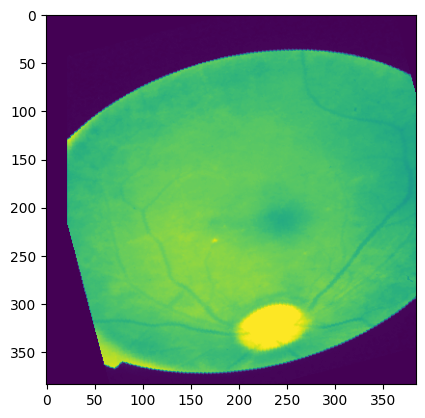

In [5]:
# Testing the train dataset

plt.imshow(trianDataset[0][0][0,:,:])

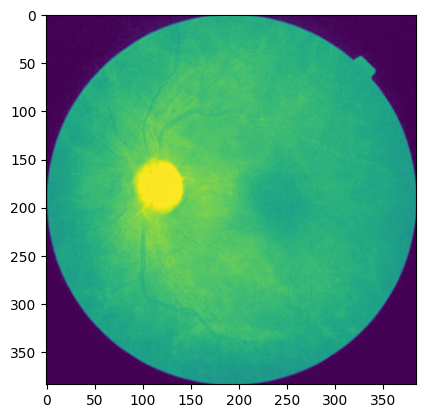

In [6]:
# Testing the test dataset

plt.imshow(testDataset[0][0][0,:,:])

In [7]:
# Putting the datasets in dataloaders

trainLoader = DataLoader(trianDataset, batch_size=32, shuffle=True)
testLoader = DataLoader(testDataset, batch_size=32, shuffle=False)

In [8]:
# Testing the dataloaders

print(len(trainLoader))
print(len(testLoader))
batch = next(iter(trainLoader))
batch[0].shape

92
12


torch.Size([32, 3, 384, 384])

## Importing and Training the Pretrained ViT_b_16

In [9]:
# Specifying a device for training

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [10]:
# urlretrieve("https://storage.googleapis.com/vit_models/imagenet21k/ViT-L_16.npz", "attention_data/ViT-L_16.npz")

In [11]:
# Loading the pretrained model

config = CONFIGS["ViT-L_16"]
model = VisionTransformer(config, num_classes=21843, zero_head=False, img_size=384, vis=True).to(device)
model.load_from(np.load("attention_data/ViT-L_16.npz"))

load_pretrained: grid-size from 14 to 24


In [12]:
# Print a summary using torchinfo (uncomment for actual output)

summary(model=model,
        input_size=(64, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

RuntimeError: Failed to run torchinfo. See above stack traces for more details. Executed layers up to: [Embeddings: 2, Conv2d: 3, Dropout: 3, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, Block: 4, LayerNorm: 5, Attention: 5, Linear: 6, Linear: 6, Linear: 6, Softmax: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Mlp: 5, Linear: 6, Dropout: 6, Linear: 6, Dropout: 6, LayerNorm: 5, Linear: 6, Linear: 6, Linear: 6]

In [12]:
# Freezing all layers except the last layer

for parameter in model.parameters():
    parameter.requires_grad = False

In [13]:
# Fixing the seed and customizing the model to fit our data

torch.manual_seed(42)
torch.cuda.manual_seed(42)
model.head = nn.Linear(in_features=1024, out_features=2).to(device)

In [ ]:
# Checking the model summary to make sure that it is changed

summary(model=model,
        input_size=(32, 3, 384, 384), # (batch_size, color_channels, height, width)
        # col_names=["input_size"], # uncomment for smaller output
        col_names=["input_size", "output_size", "num_params", "trainable"],
        col_width=20,
        row_settings=["var_names"]
)

In [14]:
"""
Contains functions for training and testing a PyTorch model.
"""

def train_step(model: torch.nn.Module,
               dataloader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               device: torch.device) -> Tuple[float, float]:
    """Trains a PyTorch model for a single epoch.

    Turns a target PyTorch model to training mode and then
    runs through all of the required training steps (forward
    pass, loss calculation, optimizer step).

    Args:
    model: A PyTorch model to be trained.
    dataloader: A DataLoader instance for the model to be trained on.
    loss_fn: A PyTorch loss function to minimize.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of training loss and training accuracy metrics.
    In the form (train_loss, train_accuracy). For example:

    (0.1112, 0.8743)
    """
    # Put model in train mode
    model.train()

    # Setup train loss and train accuracy values
    train_loss, train_acc = 0, 0

    # Loop through data loader data batches
    for batch, (X, y) in enumerate(dataloader):
        # Send data to target device
        X, y = X.to(device), y.to(device)

        # 1. Forward pass
        y_pred = model(X)[0]

        # 2. Calculate  and accumulate loss
        loss = loss_fn(y_pred, y)
        train_loss += loss.item()

        # 3. Optimizer zero grad
        optimizer.zero_grad()

        # 4. Loss backward
        loss.backward()

        # 5. Optimizer step
        optimizer.step()

        # Calculate and accumulate accuracy metric across all batches
        y_pred_class = torch.argmax(torch.softmax(y_pred, dim=1), dim=1)
        train_acc += (y_pred_class == y).sum().item()/len(y_pred)

    # Adjust metrics to get average loss and accuracy per batch
    train_loss = train_loss / len(dataloader)
    train_acc = train_acc / len(dataloader)
    return train_loss, train_acc

def test_step(model: torch.nn.Module,
              dataloader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              device: torch.device) -> Tuple[float, float]:
    """Tests a PyTorch model for a single epoch.

    Turns a target PyTorch model to "eval" mode and then performs
    a forward pass on a testing dataset.

    Args:
    model: A PyTorch model to be tested.
    dataloader: A DataLoader instance for the model to be tested on.
    loss_fn: A PyTorch loss function to calculate loss on the test data.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A tuple of testing loss and testing accuracy metrics.
    In the form (test_loss, test_accuracy). For example:

    (0.0223, 0.8985)
    """
    # Put model in eval mode
    model.eval()

    # Setup test loss and test accuracy values
    test_loss, test_acc = 0, 0

    # Turn on inference context manager
    with torch.inference_mode():
        # Loop through DataLoader batches
        for batch, (X, y) in enumerate(dataloader):
            # Send data to target device
            X, y = X.to(device), y.to(device)

            # 1. Forward pass
            test_pred_logits = model(X)[0]

            # 2. Calculate and accumulate loss
            loss = loss_fn(test_pred_logits, y)
            test_loss += loss.item()

            # Calculate and accumulate accuracy
            test_pred_labels = test_pred_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    # Adjust metrics to get average loss and accuracy per batch
    test_loss = test_loss / len(dataloader)
    test_acc = test_acc / len(dataloader)
    return test_loss, test_acc

def train(model: torch.nn.Module,
          train_dataloader: torch.utils.data.DataLoader,
          test_dataloader: torch.utils.data.DataLoader,
          optimizer: torch.optim.Optimizer,
          loss_fn: torch.nn.Module,
          epochs: int,
          device: torch.device) -> Dict[str, List]:
    """Trains and tests a PyTorch model.

    Passes a target PyTorch models through train_step() and test_step()
    functions for a number of epochs, training and testing the model
    in the same epoch loop.

    Calculates, prints and stores evaluation metrics throughout.

    Args:
    model: A PyTorch model to be trained and tested.
    train_dataloader: A DataLoader instance for the model to be trained on.
    test_dataloader: A DataLoader instance for the model to be tested on.
    optimizer: A PyTorch optimizer to help minimize the loss function.
    loss_fn: A PyTorch loss function to calculate loss on both datasets.
    epochs: An integer indicating how many epochs to train for.
    device: A target device to compute on (e.g. "cuda" or "cpu").

    Returns:
    A dictionary of training and testing loss as well as training and
    testing accuracy metrics. Each metric has a value in a list for
    each epoch.
    In the form: {train_loss: [...],
              train_acc: [...],
              test_loss: [...],
              test_acc: [...]}
    For example if training for epochs=2:
             {train_loss: [2.0616, 1.0537],
              train_acc: [0.3945, 0.3945],
              test_loss: [1.2641, 1.5706],
              test_acc: [0.3400, 0.2973]}
    """
    # Create empty results dictionary
    results = {"train_loss": [],
               "train_acc": [],
               "test_loss": [],
               "test_acc": []
    }

    # Make sure model on target device
    model.to(device)

    # Loop through training and testing steps for a number of epochs
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss, test_acc = test_step(model=model,
          dataloader=test_dataloader,
          loss_fn=loss_fn,
          device=device)

        # Print out what's happening
        print(
          f"Epoch: {epoch+1} | "
          f"train_loss: {train_loss:.4f} | "
          f"train_acc: {train_acc:.4f} | "
          f"test_loss: {test_loss:.4f} | "
          f"test_acc: {test_acc:.4f}"
        )

        # Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    # Return the filled results at the end of the epochs
    return results

In [15]:
# Create optimizer and loss function

optimizer = torch.optim.Adam(params=model.parameters(), lr=1e-3)
loss_fn = torch.nn.CrossEntropyLoss()

In [16]:
# Train the model

pretrained_vit_results = train(model=model,
                                      train_dataloader=trainLoader,
                                      test_dataloader=testLoader,
                                      optimizer=optimizer,
                                      loss_fn=loss_fn,
                                      epochs=10,
                                      device=device)

Epoch: 1 | train_loss: 0.4438 | train_acc: 0.8302 | test_loss: 0.3154 | test_acc: 0.9211
Epoch: 2 | train_loss: 0.2906 | train_acc: 0.8966 | test_loss: 0.2392 | test_acc: 0.9315
Epoch: 3 | train_loss: 0.2621 | train_acc: 0.9073 | test_loss: 0.2592 | test_acc: 0.8891
Epoch: 4 | train_loss: 0.2253 | train_acc: 0.9255 | test_loss: 0.1678 | test_acc: 0.9472
Epoch: 5 | train_loss: 0.2131 | train_acc: 0.9291 | test_loss: 0.2041 | test_acc: 0.9152
Epoch: 6 | train_loss: 0.2067 | train_acc: 0.9292 | test_loss: 0.1693 | test_acc: 0.9368
Epoch: 7 | train_loss: 0.2069 | train_acc: 0.9368 | test_loss: 0.1448 | test_acc: 0.9550
Epoch: 8 | train_loss: 0.2017 | train_acc: 0.9252 | test_loss: 0.1609 | test_acc: 0.9342
Epoch: 9 | train_loss: 0.1824 | train_acc: 0.9430 | test_loss: 0.1773 | test_acc: 0.9230
Epoch: 10 | train_loss: 0.1828 | train_acc: 0.9402 | test_loss: 0.1438 | test_acc: 0.9394



In [17]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [18]:
torch.save(model, "/content/drive/MyDrive/Trained_Models/ViT_l_16_APTOS.pt")

## Visualizing the Results

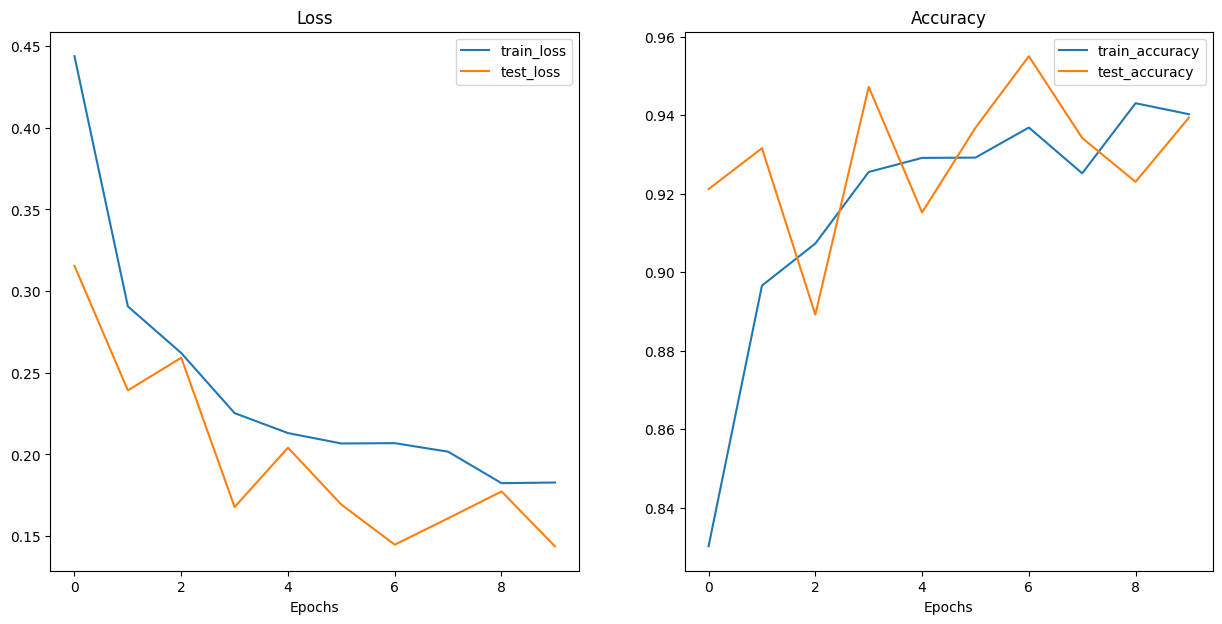

In [19]:
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()


plot_loss_curves(pretrained_vit_results)

In [20]:
csv_file_path = '/content/test.csv'
df = pd.read_csv(csv_file_path)
column_name = 'diagnosis'
y_true = df[column_name].tolist()

print(f"Values from '{column_name}': {y_true}")


Values from 'diagnosis': [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1,

In [21]:
y_pred = []
with torch.no_grad():
    for batch in testLoader:
        inputs, _ = batch  # Assuming your dataset returns (input, label)
        inputs = inputs.to(device)
        outputs = model(inputs)[0]
        _, predicted_classes = outputs.max(1)  # Get the index of the predicted class
        y_pred.extend(predicted_classes.tolist())

print(f"All predictions: {y_pred}")

All predictions: [0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 1, 1, 0, 1, 1, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 0, 1, 1, 0, 1, 0, 0, 1

              precision    recall  f1-score   support

           0       0.92      0.97      0.95       199
           1       0.97      0.90      0.93       167

    accuracy                           0.94       366
   macro avg       0.94      0.94      0.94       366
weighted avg       0.94      0.94      0.94       366

kappa_score =  0.8781513876698648


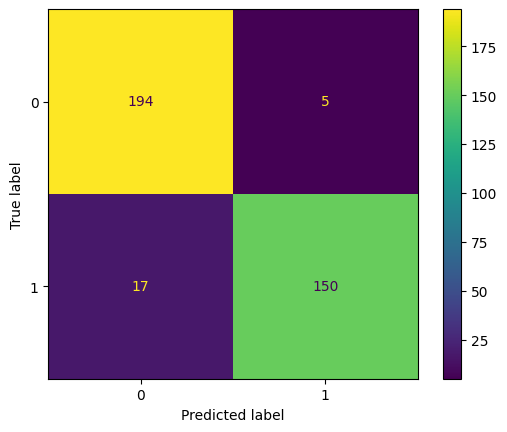

In [22]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay, cohen_kappa_score

ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred)).plot()
print(classification_report(y_true, y_pred, target_names=["0","1"]))
print("kappa_score = ", cohen_kappa_score(y_true, y_pred))

In [24]:
model.eval()

transform = transforms.Compose([
    transforms.Resize((384, 384)),
    transforms.ToTensor(),
    normalize,
])
im = Image.open("/content/train_images/fda39982a810.png")
x = transform(im).to(device)
x.size()

torch.Size([3, 384, 384])

In [25]:
logits, att_mat = model(x.unsqueeze(0))

att_mat = torch.stack(att_mat).squeeze(1)

# Average the attention weights across all heads.
att_mat = torch.mean(att_mat, dim=1)

# To account for residual connections, we add an identity matrix to the
# attention matrix and re-normalize the weights.
residual_att = torch.eye(att_mat.size(1)).to(device)
aug_att_mat = att_mat + residual_att
aug_att_mat = aug_att_mat / aug_att_mat.sum(dim=-1).unsqueeze(-1)

# Recursively multiply the weight matrices
joint_attentions = torch.zeros(aug_att_mat.size()).to(device)
joint_attentions[0] = aug_att_mat[0].to(device)

for n in range(1, aug_att_mat.size(0)):
    joint_attentions[n] = torch.matmul(aug_att_mat[n], joint_attentions[n-1])

# Attention from the output token to the input space.
v = joint_attentions[-1]
grid_size = int(np.sqrt(aug_att_mat.size(-1)))
mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
result = (mask * im).astype("uint8")

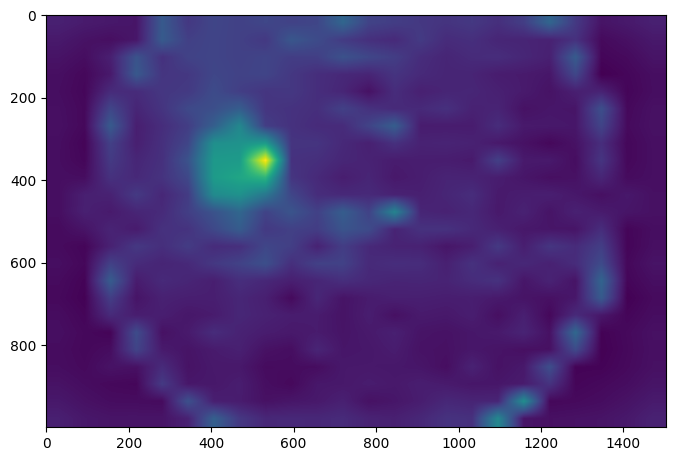

In [26]:
fig, ax = plt.subplots(ncols=1, figsize=(8, 8))

_ = ax.imshow(mask)

Prediction Label and Attention Map!

0.83746 : 1
0.16254 : 0


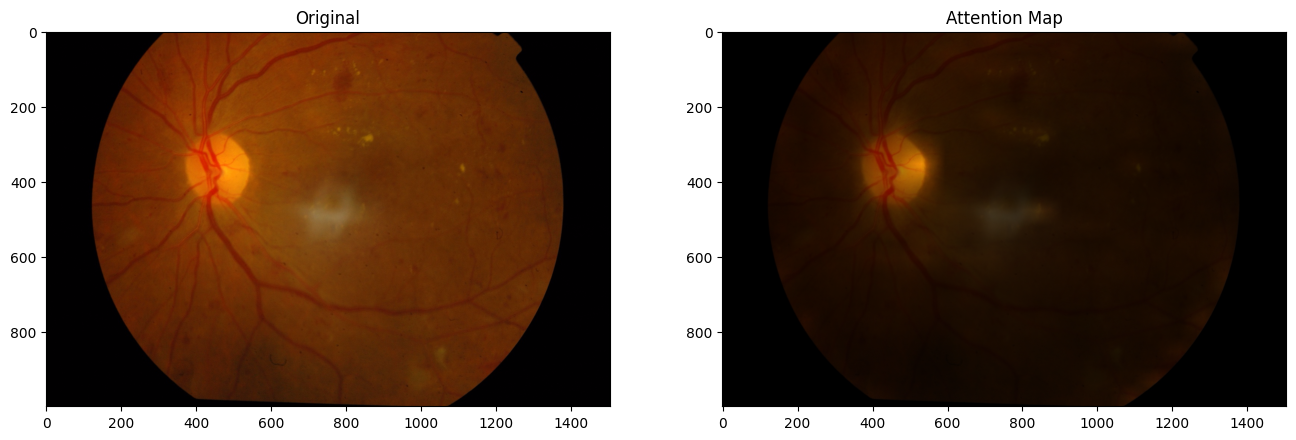

In [27]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
ax1.set_title('Original')
ax2.set_title('Attention Map')
_ = ax1.imshow(im)
_ = ax2.imshow(result)

probs = torch.nn.Softmax(dim=-1)(logits)
top5 = torch.argsort(probs, dim=-1, descending=True)
print("Prediction Label and Attention Map!\n")
for idx in top5[0, :5]:
    print(f'{probs[0, idx.item()]:.5f} : {["0","1"][idx.item()]}', end='')
    print()

In [28]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(mask)

Output hidden; open in https://colab.research.google.com to view.

In [29]:
for i, v in enumerate(joint_attentions):
    # Attention from the output token to the input space.
    mask = v[0, 1:].reshape(grid_size, grid_size).cpu().detach().numpy()
    mask = cv2.resize(mask / mask.max(), im.size)[..., np.newaxis]
    result = (mask * im).astype("uint8")

    fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(16, 16))
    ax1.set_title('Original')
    ax2.set_title('Attention Map_%d Layer' % (i+1))
    _ = ax1.imshow(im)
    _ = ax2.imshow(result)

Output hidden; open in https://colab.research.google.com to view.